# Obtaining Daily Volatility 
Get hourly candlestick data from Binance Klines

### We calculate Realised Volatility for x days given a trading pair on Binance

In [422]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import concurrent.futures
import numpy as np
import time

def fetch_data(symbol, interval, start_time, end_time):
    url = "https://api.binance.com/api/v3/klines"
    params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': 1000
    }
    data = requests.get(url, params=params).json()
    return data

def threaded_fetching(symbol, interval, start_time, end_time):

    delta = 1000 * 60 * 60 * 24  # 1 day in milliseconds
    all_data = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # distribute requests
        futures = [executor.submit(fetch_data, symbol, interval, t, min(t+delta, end_time)) for t in range(start_time, end_time, delta)]
        for future in concurrent.futures.as_completed(futures):
            all_data.extend(future.result())
    df = pd.DataFrame(all_data, columns=['open_time','open','high','low','close','volume','close_time','quote_asset_volume',
                                         'number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'])
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    return df

def calculate_volatility(df):
    df['close'] = pd.to_numeric(df['close'])
    df.set_index('open_time', inplace=True)
    df = df.resample('1H').last()
    df['log_return'] = np.log(df['close'] / df['close'].shift())
    df = df.resample('1D').std()
    df['log_return'] = df['log_return'] * np.sqrt(24) * 100  # annualize volatility
    return df[['log_return']]

def plot_volatility(df):
    df.plot()
    plt.title("Daily Realised Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility (%)")
    plt.grid(True)
    plt.show()

def fetch_pair(symbol1, symbol2, interval, start_time, end_time):
    df1 = threaded_fetching(symbol=symbol1, interval=interval, start_time=start_time, end_time=end_time)
    df2 = threaded_fetching(symbol=symbol2, interval=interval, start_time=start_time, end_time=end_time)

    # Convert the 'close' column to numeric
    df1['close'] = pd.to_numeric(df1['close'])
    df2['close'] = pd.to_numeric(df2['close'])
    
    # Make sure that the two dataframes have the same index
    df1.set_index('open_time', inplace=True)
    df2.set_index('open_time', inplace=True)   
    
    # Resample to the millisecond level to maintain precision
    df1 = df1.resample('L').last().ffill()
    df2 = df2.resample('L').last().ffill()

    # Combine the two dataframes into one
    df = pd.concat([df1['open_time'],df1['close'], df2['close']], axis=1)
    df.columns = ['open_time',symbol1, symbol2]

    # Calculate the ratio of the two pairs
    df['close'] = df[symbol1] / df[symbol2]
    
    return df


### TODO: If trading pair not on Binance, write function to find volatility by routing through USDT

# Calculating LVR based on theoretical Formula

$$
\frac{l(\sigma^2,P)}{V(P)} = \frac{\frac{L\sigma^2}{4}\sqrt{P}}{L(2\sqrt{P} \  - \ P/\sqrt{P_b} \ - \ \sqrt{P_a})}
$$

$$
\frac{l(\sigma^2,P)}{V(P)} = \frac{\sigma^2\sqrt{P}}{4(2\sqrt{P} \  - \ P/\sqrt{P_b} \ - \ \sqrt{P_a})}
$$

### We can obtain L, Pb and Pa of a given position ID on Uniswap V3 using Revert Finance

In [295]:
import requests
import pprint

def get_position_data(position_id):
    url = f'https://staging-api.revert.finance/v1/positions/mainnet/uniswapv3/{position_id}'
    headers = {
        'Accept': '*/*',
        'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8',
        'Connection': 'keep-alive',
        'Origin': 'https://revert.finance',
        'Referer': 'https://revert.finance/',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-site',
        'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
        'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
        'sec-ch-ua-mobile': '?1',
        'sec-ch-ua-platform': '"Android"'
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    return response.json()



In [296]:
import math

def get_position_details(position_id):
    position_data = get_position_data(position_id)

    P = float(position_data['data']['pool_price'])
    Pa = float(position_data['data']['price_lower'])
    Pb = float(position_data['data']['price_upper'])
    L = float(position_data['data']['liquidity'])
    pool_value = float(position_data['data']['underlying_value'])

    return P, Pa, Pb, L, pool_value

def calculate_ratio(sigma_squared, P, Pb, Pa):
    numerator = sigma_squared * math.sqrt(P)
    denominator = 4 * (2 * math.sqrt(P) - P / math.sqrt(Pb) - math.sqrt(Pa))
    ratio = numerator / denominator
    return ratio

### Some helper functions

In [103]:
from web3 import Web3
import time
import requests

# Initialize a Web3 instance
w3 = Web3(Web3.HTTPProvider('https://eth.llamarpc.com'))

# get timestamp for a given block
def get_timestamp(block_number):
    block = w3.eth.get_block(block_number)
    return block.timestamp * 1000

# get timestamp for current time
def get_current_timestamp():
    return int(time.time()) * 1000

# get block from timestamp using llama fi endpoint https://coins.llama.fi/block/ethereum/{timestamp}

def get_block_from_timestamp(timestamp):
    url = f"https://coins.llama.fi/block/ethereum/{timestamp}"
    try:
        response = requests.get(url)
        data = response.json()
        block_number = data["height"]
        return block_number
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None
    
def get_date(timestamp):
    return datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d')   

def get_eth_price():
    url = "https://api.coingecko.com/api/v3/simple/price"
    params = {
        "ids": "ethereum",
        "vs_currencies": "usd"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        eth_price = data["ethereum"]["usd"]
        return eth_price
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None
    
def get_coin_historical(timestamp,address):
    url = f"https://coins.llama.fi/prices/historical/{timestamp}/ethereum:{address}?searchWidth=4h"
    try:
        response = requests.get(url)
        data = response.json()
        return data['coins'][f'ethereum:{address}']['price']
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None

### Getting Position data based on NFT Position ID

In [318]:
uniswap_positions_nft_abi = uniswap_positions_nft_abi = '[{"inputs":[{"internalType":"address","name":"_factory","type":"address"},{"internalType":"address","name":"_WETH9","type":"address"},{"internalType":"address","name":"_tokenDescriptor_","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"approved","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"operator","type":"address"},{"indexed":false,"internalType":"bool","name":"approved","type":"bool"}],"name":"ApprovalForAll","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"DecreaseLiquidity","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"IncreaseLiquidity","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[],"name":"DOMAIN_SEPARATOR","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"PERMIT_TYPEHASH","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"WETH9","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"approve","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"baseURI","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"burn","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Max","type":"uint128"},{"internalType":"uint128","name":"amount1Max","type":"uint128"}],"internalType":"struct INonfungiblePositionManager.CollectParams","name":"params","type":"tuple"}],"name":"collect","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"createAndInitializePoolIfNecessary","outputs":[{"internalType":"address","name":"pool","type":"address"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"amount0Min","type":"uint256"},{"internalType":"uint256","name":"amount1Min","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"internalType":"struct INonfungiblePositionManager.DecreaseLiquidityParams","name":"params","type":"tuple"}],"name":"decreaseLiquidity","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"getApproved","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"amount0Desired","type":"uint256"},{"internalType":"uint256","name":"amount1Desired","type":"uint256"},{"internalType":"uint256","name":"amount0Min","type":"uint256"},{"internalType":"uint256","name":"amount1Min","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"internalType":"struct INonfungiblePositionManager.IncreaseLiquidityParams","name":"params","type":"tuple"}],"name":"increaseLiquidity","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"operator","type":"address"}],"name":"isApprovedForAll","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint256","name":"amount0Desired","type":"uint256"},{"internalType":"uint256","name":"amount1Desired","type":"uint256"},{"internalType":"uint256","name":"amount0Min","type":"uint256"},{"internalType":"uint256","name":"amount1Min","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"internalType":"struct INonfungiblePositionManager.MintParams","name":"params","type":"tuple"}],"name":"mint","outputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ownerOf","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"permit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"positions","outputs":[{"internalType":"uint96","name":"nonce","type":"uint96"},{"internalType":"address","name":"operator","type":"address"},{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"refundETH","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"bytes","name":"_data","type":"bytes"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"nonce","type":"uint256"},{"internalType":"uint256","name":"expiry","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitAllowed","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"nonce","type":"uint256"},{"internalType":"uint256","name":"expiry","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitAllowedIfNecessary","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitIfNecessary","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"bool","name":"approved","type":"bool"}],"name":"setApprovalForAll","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes4","name":"interfaceId","type":"bytes4"}],"name":"supportsInterface","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"name":"sweepToken","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenOfOwnerByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"tokenURI","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"transferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount0Owed","type":"uint256"},{"internalType":"uint256","name":"amount1Owed","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"uniswapV3MintCallback","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"name":"unwrapWETH9","outputs":[],"stateMutability":"payable","type":"function"},{"stateMutability":"payable","type":"receive"}]'

def get_position_nft_data(position_id,block):
    contract_address = "0xC36442b4a4522E871399CD717aBDD847Ab11FE88"
    contract = w3.eth.contract(address=contract_address, abi=uniswap_positions_nft_abi)
    return contract.functions.positions(position_id).call(block_identifier=block)

### Liquidity Math helper functions

In [371]:
import math

Q96 = 2**96

def get_tick_at_sqrt_ratio(sqrt_price_x96):
    tick = math.floor(math.log((sqrt_price_x96 / Q96) ** 2) / math.log(1.0001))
    return tick

def get_token_amounts(liquidity, sqrt_price_x96, tick_low, tick_high, token_0_decimal, token_1_decimal):
    sqrt_ratio_a = math.sqrt(1.0001 ** tick_low)
    sqrt_ratio_b = math.sqrt(1.0001 ** tick_high)
    
    current_tick = get_tick_at_sqrt_ratio(sqrt_price_x96)
    sqrt_price = sqrt_price_x96 / Q96
    
    amount_0_wei = 0
    amount_1_wei = 0
    if current_tick <= tick_low:
        amount_0_wei = math.floor(liquidity * ((sqrt_ratio_b-sqrt_ratio_a)/(sqrt_ratio_a*sqrt_ratio_b)))
    elif current_tick > tick_high:
        amount_1_wei = math.floor(liquidity * (sqrt_ratio_b-sqrt_ratio_a))
    elif current_tick >= tick_low and current_tick < tick_high: 
        amount_0_wei = math.floor(liquidity * ((sqrt_ratio_b-sqrt_price)/(sqrt_price*sqrt_ratio_b)))
        amount_1_wei = math.floor(liquidity * (sqrt_price-sqrt_ratio_a))
    
    amount_0_human = round(amount_0_wei / 10**token_0_decimal, token_0_decimal)
    amount_1_human = round(amount_1_wei / 10**token_1_decimal, token_1_decimal)
    return [amount_0_human, amount_1_human]

def priceToSqrtPrice(price,decimal0, decimal1):
    # convert this to an equation, multiply the square root of price multiplied by 10 to the power of decimal 1 - 0 with 2 to the power of 96
    sqrtPrice = math.sqrt(price * 10 ** (decimal1 - decimal0)) * 2 ** 96
    return int(sqrtPrice)

### For Uniswap V3 NFT Positions

In [375]:
from abi import v3_pool_abi, erc20_abi
import pandas as pd
import concurrent.futures

def get_position_data_block_range(block_range, position_id, pool_address, token0_decimals, token1_decimals):
    data_list = []
    for block in block_range:
        position_data = get_position_nft_data(position_id, block)

        tickLower = position_data[5]
        tickUpper = position_data[6]
        tokensOwed0 = position_data[10]
        tokensOwed1 = position_data[11]
        liquidity = position_data[7]

        pool_contract = w3.eth.contract(address=pool_address, abi=v3_pool_abi)
        current_tick = pool_contract.functions.slot0().call(block_identifier=block)[1]
        upper_price = (1.0001 ** tickUpper) / (10 ** (token1_decimals - token0_decimals))
        lower_price = (1.0001 ** tickLower) / (10 ** (token1_decimals - token0_decimals))
        current_price = (1.0001 ** current_tick) / (10 ** (token1_decimals - token0_decimals))

        sqrtPriceLower = priceToSqrtPrice(lower_price, token0_decimals, token1_decimals)
        sqrtPriceUpper = priceToSqrtPrice(upper_price, token0_decimals, token1_decimals)
        sqrtPriceCurrent = priceToSqrtPrice(current_price, token0_decimals, token1_decimals)

        amounts = get_token_amounts(liquidity, sqrtPriceCurrent, tickLower, tickUpper, token0_decimals, token1_decimals)
        amount0 = amounts[0]
        amount1 = amounts[1]

        pool_value = (amount0 * current_price) + amount1

        data_list.append({
            'block': block,
            'current_tick': current_tick,
            'upper_price': upper_price,
            'lower_price': lower_price,
            'current_price': current_price,
            'tokensOwed0': tokensOwed0,
            'tokensOwed1': tokensOwed1,
            'amount0': amount0,
            'amount1': amount1,
            'pool_value': pool_value
        })

    return data_list

def get_position_details(position_id, pool_address, start_timestamp, end_timestamp, num_threads=7):

    start_block = get_block_from_timestamp(start_timestamp / 1000)
    end_block = w3.eth.block_number

    # Get the token0 and token1 contract details
    position_data = get_position_nft_data(position_id, end_block)
    token0 = position_data[2]
    token1 = position_data[3]

    token0_contract = w3.eth.contract(address=token0, abi=erc20_abi)
    token1_contract = w3.eth.contract(address=token1, abi=erc20_abi)
    token0_decimals = token0_contract.functions.decimals().call(block_identifier=end_block)
    token1_decimals = token1_contract.functions.decimals().call(block_identifier=end_block)

    block_step = 7200  # number of blocks in one day
    blocks = list(range(start_block, end_block, block_step))
    block_chunks = list(chunks(blocks, len(blocks) // num_threads))

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(get_position_data_block_range, block_chunks,
          [position_id]*len(block_chunks), [pool_address]*len(block_chunks), 
          [token0_decimals]*len(block_chunks), [token1_decimals]*len(block_chunks)))

    details = [detail for sublist in results for detail in sublist]  # flatten the results

    df = pd.DataFrame(details)
    return df

In [376]:
start = get_timestamp(17285193)
end = get_current_timestamp()
df = get_position_details(453456, "0xD1D5A4c0eA98971894772Dcd6D2f1dc71083C44E",start,end, num_threads=7)

### For Range Protocol Vaults: We query the given block range for lowerTick, upperTick, and pool_value

In [305]:
import pandas as pd
import concurrent.futures
from abi import pool_abi, v3_pool_abi, erc20_abi

def get_data_for_block_range(block_range):
    details = []
    for block in block_range:
        upper_tick = pool_contract.functions.upperTick().call(block_identifier=block)
        lower_tick = pool_contract.functions.lowerTick().call(block_identifier=block)
        fees = pool_contract.functions.getCurrentFees().call(block_identifier=block)
        fee0 = fees[0] / 10 ** token0_decimals
        fee1 = fees[1] / 10 ** token1_decimals
        underlying_balances = pool_contract.functions.getUnderlyingBalances().call(block_identifier=block)
        amount0 = underlying_balances[0] / 10 ** token0_decimals
        amount1 = underlying_balances[1] / 10 ** token1_decimals
        current_tick = v3_pool_contract.functions.slot0().call(block_identifier=block)[1]
        upper_price = (1.0001 ** upper_tick) / (10**(token1_decimals-token0_decimals))
        lower_price = (1.0001 ** lower_tick) / (10**(token1_decimals-token0_decimals))
        current_price = (1.0001 ** current_tick) / (10**(token1_decimals-token0_decimals))
        pool_value = (amount0 * current_price) + amount1
        current_fees = (fee0 * current_price) + fee1
        details.append({
            'block': block,
            'lower_price': lower_price, 
            'upper_price': upper_price,
            'current_price': current_price, 
            'pool_value': pool_value,
            'current_fees': current_fees,
            'timestamp': get_timestamp(block),
            'date': get_date(get_timestamp(block)),
            'token0_usd': get_coin_historical(get_timestamp(block)/1000,token0),
            'token1_usd': get_coin_historical(get_timestamp(block)/1000,token1),
        })
    return details

def chunks(lst, n):
    # Yield successive n-sized chunks from lst
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_range_position_details(pool_address, start_timestamp, end_timestamp, num_threads=7):

    # Initialize a Web3 instance
    w3 = Web3(Web3.HTTPProvider('https://eth-mainnet.g.alchemy.com/v2/OV2Uqs1tC70MAtl88BcFArffiXobkx6T'))

    # Assume a function get_block_number(timestamp)
    start_block = get_block_from_timestamp(start_timestamp/1000)
    end_block = get_block_from_timestamp(end_timestamp/1000)

    global pool_contract
    pool_contract = w3.eth.contract(address=pool_address, abi=pool_abi)
    name = pool_contract.functions.name().call(block_identifier=start_block)
    global token0
    token0 = pool_contract.functions.token0().call(block_identifier=start_block)
    global token1
    token1 = pool_contract.functions.token1().call(block_identifier=start_block)

    token0_contract = w3.eth.contract(address=token0, abi=erc20_abi)
    token1_contract = w3.eth.contract(address=token1, abi=erc20_abi)
    global token0_decimals
    token0_decimals = token0_contract.functions.decimals().call(block_identifier=start_block)
    global token1_decimals
    token1_decimals = token1_contract.functions.decimals().call(block_identifier=start_block)
    token0_name = token0_contract.functions.name().call(block_identifier=start_block)
    token1_name = token1_contract.functions.name().call(block_identifier=start_block)

    # Get Pool in Uniswap V3
    pool = pool_contract.functions.pool().call(block_identifier=start_block)
    global v3_pool_contract
    v3_pool_contract = w3.eth.contract(address=pool, abi=v3_pool_abi)
    block_step = 7200 # number of blocks in one 1 day
    blocks = list(range(start_block, end_block, block_step))
    block_chunks = list(chunks(blocks, len(blocks)//num_threads))

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(get_data_for_block_range, block_chunks))

    details = [detail for sublist in results for detail in sublist]  # flatten the results

    # Convert to DataFrame
    df = pd.DataFrame(details)

    return df,token0,token1

In [420]:
start = get_timestamp(17285193)
end = get_current_timestamp()
df = threaded_fetching('ETHUSDC', '1m', start, end)
df2 = df.copy()
volatility_df = calculate_volatility(df)
volatility_df.reset_index(inplace=True)

In [ ]:
start = get_timestamp(17285193)
end = get_current_timestamp()
df = fetch_pair("LQTYUSDT", "ETHUSDT", "1d", start, end)


In [ ]:
volatility_df = calculate_volatility(df)
volatility_df.reset_index(inplace=True)

In [378]:
range_pool = "0x350D81A7733Ee6b001966e0844A0ebb096FAbF0f"
range_position,token0,token1 = get_range_position_details(range_pool, start, end)


### Merge volatility and position data

In [410]:
# convert open_time in volatility_df and date in range_position to the same type
volatility_df['open_time'] = pd.to_datetime(volatility_df['open_time'])
range_position['date'] = pd.to_datetime(range_position['date'])

# merge volatility_df and range_position based on open_time and date
merged_df = pd.merge(volatility_df, range_position, how='inner', left_on='open_time', right_on='date')

# compute daily LVR ratio by using calculate ratio
merged_df['daily_LVR_ratio'] = merged_df.apply(lambda x: calculate_ratio(x['log_return'], x['current_price'], x['upper_price'], x['lower_price']), axis=1)

# if upper_price and lower_price are the same, then the daily LVR ratio is 0
merged_df.loc[merged_df['upper_price'] == merged_df['lower_price'], 'daily_LVR_ratio'] = 0

# compute daily LVR by dividing daily LVR ratio by 10000 and multiplying with Pool Value
merged_df['daily_LVR'] = merged_df.apply(lambda x: x['daily_LVR_ratio']/10000 * x['pool_value'], axis=1)

# create column for cumulative LVR
merged_df['cumulative_LVR'] = merged_df['daily_LVR'].cumsum()

In [411]:
# Initialize variables
previous_fee = merged_df['current_fees'].iloc[0]
fee_to_add = 0

merged_df['collected_fees'] = merged_df['current_fees']

# Iterate over the dataframe
for i, current_fee in enumerate(merged_df['current_fees']):

    if current_fee < (previous_fee * 0.1):
        fee_to_add = previous_fee
        merged_df['collected_fees'].iloc[i] += fee_to_add
    else:
        merged_df['collected_fees'].iloc[i] += fee_to_add

    previous_fee = merged_df['collected_fees'].iloc[i]

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/1520530701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['collected_fees'].iloc[i] += fee_to_add
/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/1520530701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['collected_fees'].iloc[i] += fee_to_add
/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/1520530701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/3485501252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


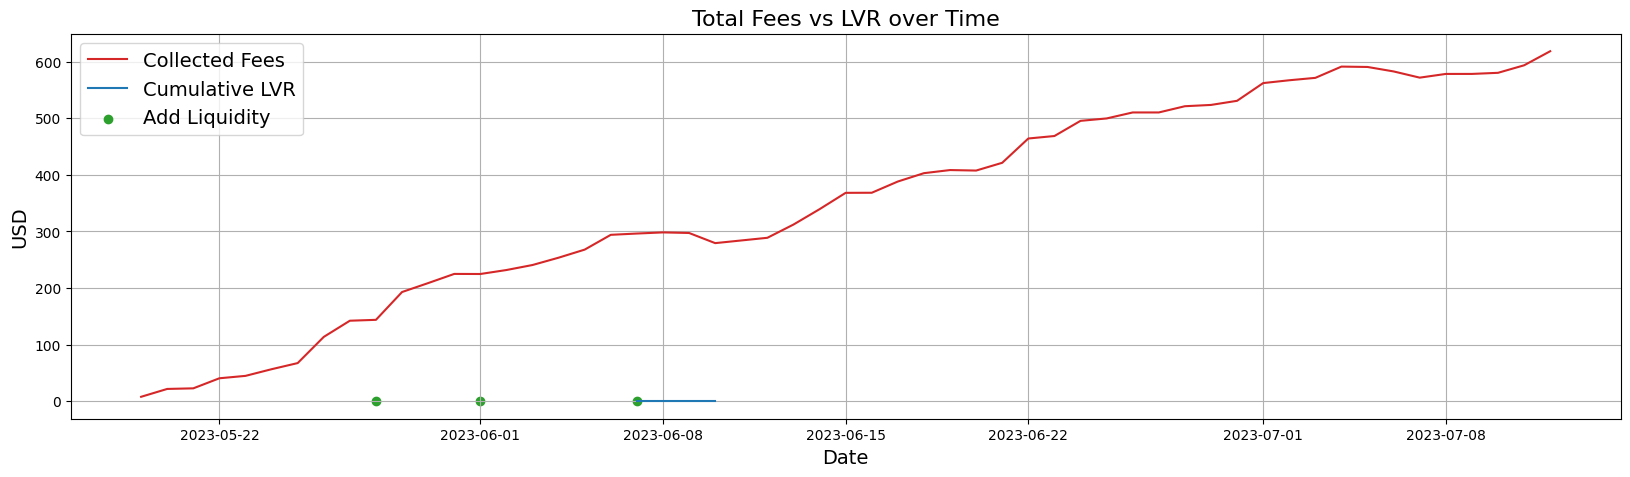

In [412]:
import matplotlib.pyplot as plt

# Select relevant columns and convert date to datetime
df = merged_df[['date','current_fees', 'collected_fees', 'cumulative_LVR','upper_price','lower_price','current_price','daily_LVR','token1_usd']]
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Flag instances where current_fees dropped by more than 90%
df['drop_flag'] = df['current_fees'].pct_change() < -0.9

# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(df['date'], df['collected_fees'] * df['token1_usd'], color='tab:red', label='Collected Fees')
plt.plot(df['date'], df['cumulative_LVR'] * df['token1_usd'], color='tab:blue', label='Cumulative LVR')
plt.scatter(df[df['drop_flag']]['date'], df[df['drop_flag']]['current_fees'] * df[df['drop_flag']]['token1_usd'], color='tab:green', label='Add Liquidity')
plt.xlabel('Date', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.title('Total Fees vs LVR over Time', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/2085248894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime


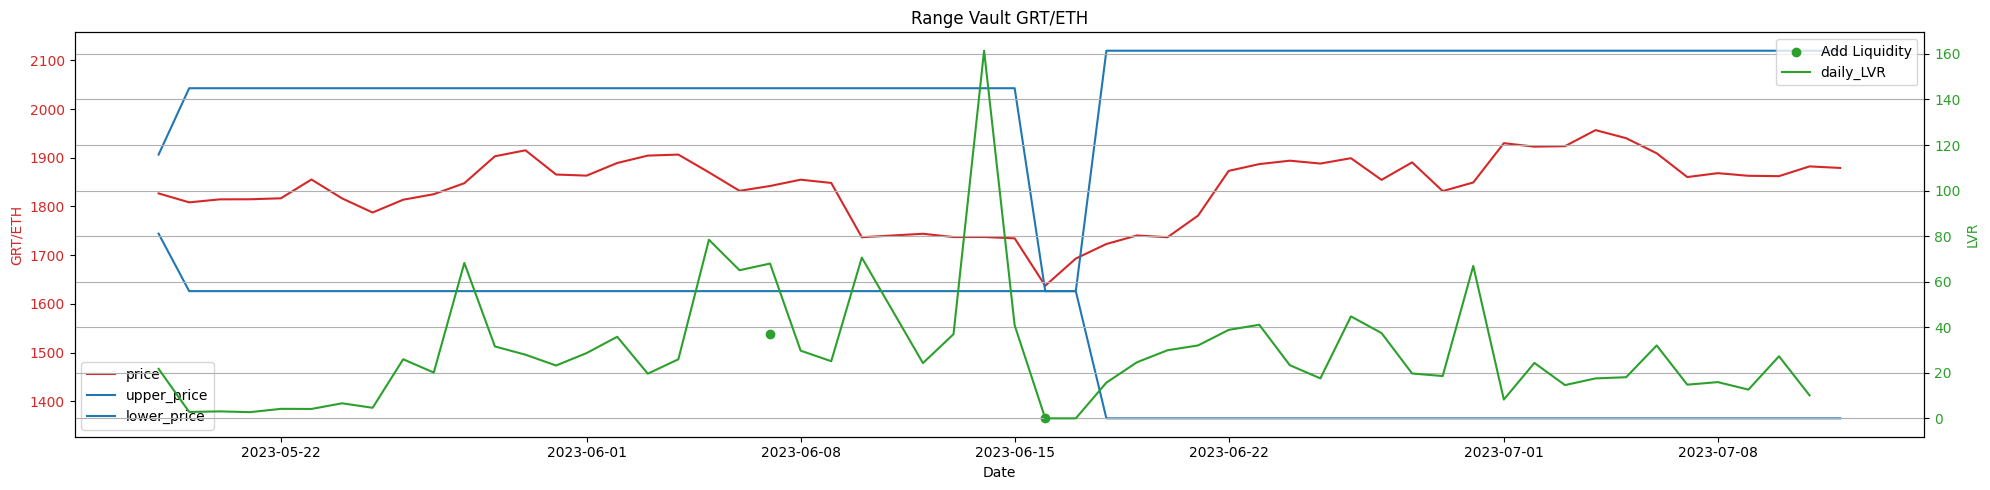

In [293]:
import matplotlib.pyplot as plt

df = merged_df[['date', 'current_fees', 'cumulative_LVR','upper_price','lower_price','current_price','daily_LVR','token1_usd']]
df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
df = df.sort_values('date')

fig, ax1 = plt.subplots(figsize=(20, 5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('GRT/ETH', color=color)
ax1.plot(df['date'], 1/df['current_price'], color=color, label='price')
ax1.plot(df['date'], 1/df['upper_price'], color='tab:blue', label='upper_price')
ax1.plot(df['date'], 1/df['lower_price'], color='tab:blue', label='lower_price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Range Vault GRT/ETH')
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Flag instances where current_fees dropped by more than 90%
df['drop_flag'] = df['current_fees'].pct_change() < -0.9
plt.scatter(df[df['drop_flag']]['date'], df[df['drop_flag']]['current_fees'] * df[df['drop_flag']]['token1_usd'], color='tab:green', label='Add Liquidity')

color = 'tab:green'
ax2.set_ylabel('LVR', color=color)  # we already handled the x-label with ax1
ax2.plot(df['date'], df['token1_usd'] * df['daily_LVR'], color=color, label='daily_LVR')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.grid(True)
plt.show()

In [173]:
merged_df

,open_time,log_return,block,lower_price,upper_price,current_price,pool_value,current_fees,timestamp,date,token0_usd,token1_usd,daily_LVR_ratio,daily_LVR,cumulative_LVR
0,2023-05-18,2.984110,17285193,0.000525,0.000573,0.000547,7.015265,0.000000,1684397831000,2023-05-18,0.999904,1826.78,16.953002,0.011893,0.011893
1,2023-05-19,0.973719,17292393,0.000490,0.000615,0.000553,7.055676,0.004860,1684485419000,2023-05-19,1.000000,1807.44,2.197176,0.001550,0.013443
2,2023-05-20,1.058170,17299593,0.000490,0.000615,0.000551,7.046469,0.007270,1684573031000,2023-05-20,1.000000,1814.58,2.387527,0.001682,0.015126
3,2023-05-21,0.943857,17306793,0.000490,0.000615,0.000551,7.047816,0.008965,1684660523000,2023-05-21,1.000000,1815.23,2.129602,0.001501,0.016627
4,2023-05-22,1.197303,17313993,0.000490,0.000615,0.000550,8.490877,0.012014,1684748255000,2023-05-22,0.999801,1816.38,2.701396,0.002294,0.018920
5,2023-05-23,1.172788,17321193,0.000490,0.000615,0.000539,8.399784,0.016682,1684835843000,2023-05-23,1.000000,1855.78,2.647814,0.002224,0.021144
6,2023-05-24,1.895322,17328393,0.000490,0.000615,0.000550,8.499673,0.020389,1684923383000,2023-05-24,1.000000,1816.98,4.276298,0.003635,0.024779
7,2023-05-25,1.341899,17335593,0.000490,0.000615,0.000559,8.570094,0.027347,1685010815000,2023-05-25,0.999881,1786.51,3.030004,0.002597,0.027376
8,2023-05-26,1.085129,17342793,0.000490,0.000615,0.000551,58.460300,0.035126,1685098235000,2023-05-26,0.999606,1812.00,2.448373,0.014313,0.041689
9,2023-05-27,0.837292,17349993,0.000490,0.000615,0.000548,58.300485,0.057390,1685185691000,2023-05-27,1.000000,1825.56,1.889095,0.011014,0.052703
